In [ ]:
pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=79e495fe81d8dc3a1815b8a4a14b231aebfb45a721bb6861d884c01d0d375b70
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
# The configuration has to be changed
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .appName("MyApp") \
    .getOrCreate()

**Open the DataFrame**

In [100]:
# File location and type
file_location = "/content/drive/MyDrive/DevelHope/FordGoBike/2017-fordgobike-tripdataa (1).csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df)

DataFrame[start_time: string, start time hour: int, start time minute: int, start time seconds: int, _c4: string, end_time: string, end_time hour: int, end_time minute: int, end_time seconds: int, _c9: string, start_station_id: int, start_station_name: string, start_station_latitude: double, start_station_longitude: double, end_station_id: int, end_station_name: string, end_station_latitude: double, end_station_longitude: double, bike_id: int, user_type: string, member_birth_year: int, member_gender: string, pyment: string]

**Calculate the duration of each trip**

In [ ]:
df.show(5)

+----------+---------------+-----------------+------------------+---+--------+-------------+---------------+----------------+---+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+---------------+
|start_time|start time hour|start time minute|start time seconds|_c4|end_time|end_time hour|end_time minute|end_time seconds|_c9|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|     pyment|duration_in_sec|
+----------+---------------+-----------------+------------------+---+--------+-------------+---------------+----------------+---+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+----

In [ ]:
## Duration functioin

def duration(h1,m1,s1,h2,m2,s2):
    sec1 = h1*3600 + m2*60 + s1
    sec2 = h2*3600 + m2*60 + s2
    
    return sec2 - sec1

In [ ]:
##Apply the function

df = df.withColumn('duration_in_sec', duration(df[1], df[2], df[3], df[6], df[7], df[8]))
df[['start time hour', 'start time minute','start time seconds','end_time hour','end_time minute','end_time seconds','duration_in_sec']].show(5)

+---------------+-----------------+------------------+-------------+---------------+----------------+---------------+
|start time hour|start time minute|start time seconds|end_time hour|end_time minute|end_time seconds|duration_in_sec|
+---------------+-----------------+------------------+-------------+---------------+----------------+---------------+
|              4|               57|                40|            3|             12|              50|          -3590|
|              3|               56|                35|            1|             49|              56|          -7179|
|             10|               45|                48|           11|             28|              37|           3589|
|              5|               31|                11|           10|             47|              24|          18013|
|              2|               23|                14|            2|             29|              58|             44|
+---------------+-----------------+------------------+--

In [ ]:
## Filter negative durations

df1 = df.filter(df['duration_in_sec'] > 0)
df1[['start time hour', 'start time minute','start time seconds','end_time hour','end_time minute','end_time seconds','duration_in_sec']].show(5)

+---------------+-----------------+------------------+-------------+---------------+----------------+---------------+
|start time hour|start time minute|start time seconds|end_time hour|end_time minute|end_time seconds|duration_in_sec|
+---------------+-----------------+------------------+-------------+---------------+----------------+---------------+
|             10|               45|                48|           11|             28|              37|           3589|
|              5|               31|                11|           10|             47|              24|          18013|
|              2|               23|                14|            2|             29|              58|             44|
|             11|               46|                37|           12|             58|              51|           3614|
|             11|               37|                 8|           12|             46|              18|           3610|
+---------------+-----------------+------------------+--

**Calculate COST**

In [ ]:
df1 = df1.withColumn("fee", (df1['duration_in_sec']/60)*0.35)
df1[['start_station_name','end_station_name','duration_in_sec','fee']].show(5)

+--------------------+--------------------+---------------+-------------------+
|  start_station_name|    end_station_name|duration_in_sec|                fee|
+--------------------+--------------------+---------------+-------------------+
|Downtown Berkeley...|Downtown Berkeley...|           3589| 20.935833333333335|
|8th St at Ringold St|Powell St BART St...|          18013| 105.07583333333332|
|Bancroft Way at T...|Fulton St at Banc...|             44|0.25666666666666665|
|Yerba Buena Cente...|Yerba Buena Cente...|           3614| 21.081666666666667|
|Mechanics Monumen...|Mechanics Monumen...|           3610|  21.05833333333333|
+--------------------+--------------------+---------------+-------------------+
only showing top 5 rows



**Add distances**

In [ ]:
from haversine import haversine 
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def distance_calc(a,b,c,d):
    return haversine( (a,b), (c,d))

distance_udf = udf(distance_calc, DoubleType())

df1 = df1.withColumn('distance', distance_udf ( df1["start_station_latitude"], df1['start_station_longitude'],df1['end_station_latitude'], df1['end_station_longitude'] ) )

display(df1[["start_station_latitude", "start_station_longitude", "end_station_latitude", "end_station_longitude", "distance"]])

DataFrame[start_station_latitude: double, start_station_longitude: double, end_station_latitude: double, end_station_longitude: double, distance: double]

#WEEK 4


In [ ]:
df1.columns

['start_time',
 'start time hour',
 'start time minute',
 'start time seconds',
 '_c4',
 'end_time',
 'end_time hour',
 'end_time minute',
 'end_time seconds',
 '_c9',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender',
 'pyment',
 'duration_in_sec',
 'fee',
 'distance']

In [ ]:
df1.show(5)

+----------+---------------+-----------------+------------------+---+--------+-------------+---------------+----------------+---+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+---------------+-------------------+------------------+
|start_time|start time hour|start time minute|start time seconds|_c4|end_time|end_time hour|end_time minute|end_time seconds|_c9|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|     pyment|duration_in_sec|                fee|          distance|
+----------+---------------+-----------------+------------------+---+--------+-------------+---------------+----------------+---+----------------+--------------------+---------

In [ ]:
df4_1 = df1.groupBy("user_type").agg({'fee':'sum'})
df4_1.show()

+----------+------------------+
| user_type|          sum(fee)|
+----------+------------------+
|Subscriber| 1468526.844166766|
|  Customer|1022791.0174999994|
+----------+------------------+



### **Week 4 Task 2**

#### Week 4 Task 2 SubTask 1

In [ ]:
from pyspark.sql import functions as F
df4_2 = df1.withColumn('pm', F.when(F.col('_c4') == 'PM',1 ).otherwise(0))
df4_2 = df4_2.withColumn('start_time_v2', df4_2['start time hour'] + (12* df4_2['pm']) )
df4_2.select("start time hour", "_c4", "start_time_v2").show(5)

+---------------+---+-------------+
|start time hour|_c4|start_time_v2|
+---------------+---+-------------+
|             10| PM|           22|
|              5| PM|           17|
|              2| PM|           14|
|             11| PM|           23|
|             11| PM|           23|
+---------------+---+-------------+
only showing top 5 rows



In [ ]:
df4_2_time = df4_2.withColumn('TIME_DAY', F.when((F.col('start_time_v2')>=5) & (F.col('start_time_v2')<12),'morning')\
                    .otherwise(F.when((F.col('start_time_v2')>=12) & (F.col('start_time_v2')<18),'Afternoon')\
                    .otherwise('Evening')
                    ))

In [ ]:
df4_2_time.show(5)

+----------+---------------+-----------------+------------------+---+--------+-------------+---------------+----------------+---+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+---------------+-------------------+------------------+---+-------------+---------+
|start_time|start time hour|start time minute|start time seconds|_c4|end_time|end_time hour|end_time minute|end_time seconds|_c9|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|     pyment|duration_in_sec|                fee|          distance| pm|start_time_v2| TIME_DAY|
+----------+---------------+-----------------+------------------+---+--------+-------------+---------------+------------

In [ ]:
df4_2_sol1=df4_2_time.groupBy('TIME_DAY').count()
df4_2_sol1.show()

+---------+------+
| TIME_DAY| count|
+---------+------+
|  Evening| 78527|
|Afternoon|113967|
|  morning|112607|
+---------+------+



#### **Week4 task 2 subtask 2**



In [ ]:
df4_2_2=df4_2.groupBy('start_time_v2').count()
df4_2_2.orderBy('start_time_v2', desc=True).show()

+-------------+-----+
|start_time_v2|count|
+-------------+-----+
|            1|  891|
|            2|  515|
|            3|  281|
|            4|  394|
|            5| 1323|
|            6| 5348|
|            7|16654|
|            8|34290|
|            9|25681|
|           10|14900|
|           11|14411|
|           12| 1055|
|           13|17131|
|           14|15796|
|           15|18404|
|           16|25982|
|           17|35599|
|           18|26793|
|           19|15506|
|           20| 9659|
+-------------+-----+
only showing top 20 rows



In [ ]:
import pandas as pd
pands_df = df4_2.toPandas() 

<Axes: xlabel='start_time_v2', ylabel='Density'>

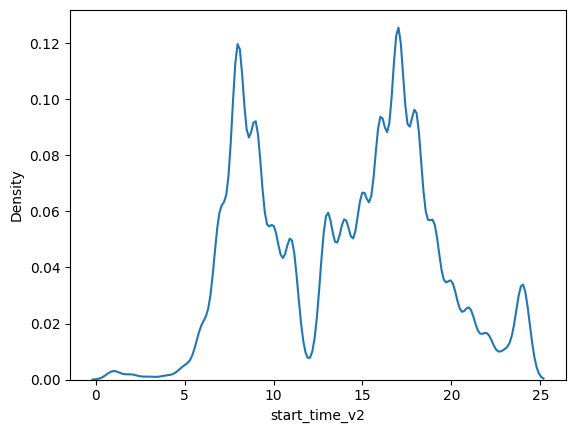

In [ ]:
import seaborn as sns
sns.kdeplot(data=pands_df, x="start_time_v2")

### **Week4 Task3**

##### Week4 Task3 

In [97]:
pands_df.start_station_name.unique().shape

(271,)

In [111]:
# Importing libraries
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(50, 250))
 
# drawing the plot
#sns.barplot(x, y, ax=ax)
#sns.set(font_scale = 4)
b = sns.boxplot(data=pands_df, x="start_time_v2", y="start_station_name", ax=ax)
labs = ax.get_yticklabels()
b.set_yticklabels(labs, size = 30)

plt.show()